In [1]:
import orcapod as op
from demo_setup.config import (
    namespace_lookup,
    data_dir,
    store_dir,
    orch,
    client,
    active_agent,
)
import demo_setup.util as demo_util

## Orcapod DEMO

A framework for fully traceable and reproducible scientific computation

## Guiding Principles

- Reproducibility
- Performance
- Simplicity
- Flexibility
- Extensibility
- Reusability
- Robustness


## Monitors


In [ ]:
# monitor active containers

# watch -n 0.5 docker ps -a


# monitor agent communication network

# clear && python -c 'import asyncio; import orcapod as op; client = op.AgentClient(group="demo", host="alpha"); asyncio.run(client.watch(key_expr="**"))'

## Setup test inputs


- `data_lake/brain_mri`: Brain MRI slices used as input



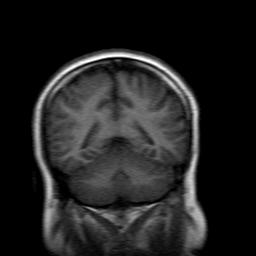
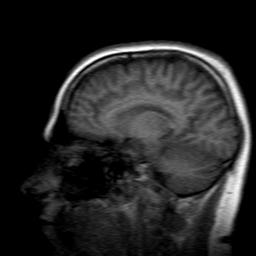
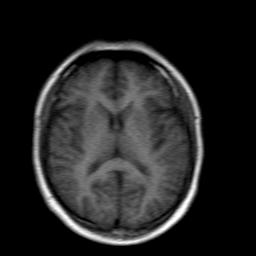

In [2]:
demo_util.display_jpegs("data_lake/brain_mri")

## Define computation


`brain_segmentation_pod` : Python computation that:

- Reads a 2D brain MRI slice (.jpeg)
- Normalizes image intensities to a stable range
- Segments the slice into four intensity-based regions
  (background / CSF-like / gray-matter-like / bright tissue)
- Generates a segmentation mask (grayscale label image)
- Generates an overlay by blending the segmentation with the original image


In [3]:
from textwrap import dedent

In [4]:
brain_segmentation_pod = op.Pod(
    image="demisto/opencv:1.0.0.4855524",
    command=[
        "bash",
        "-lc",
        "umask u=rwx,g=rwx,o=rwx && python -c '{}'".format(
            dedent(
                """
                from pathlib import Path
                import cv2
                import numpy as np

                in_path = Path("/tmp/input/subject.jpeg")
                out_dir = Path("/tmp/output")
                out_dir.mkdir(parents=True, exist_ok=True)

                img = cv2.imread(str(in_path), cv2.IMREAD_GRAYSCALE)
                if img is None:
                    raise RuntimeError(f"Failed to read image: {in_path}")

                # Normalize intensity to [0, 1]
                img_f = img.astype(np.float32)
                img_f = (img_f - img_f.min()) / (img_f.max() - img_f.min() + 1e-8)

                # Threshold-based segmentation into 4 intensity classes
                mask = np.zeros_like(img_f, dtype=np.uint8)
                mask[img_f < 0.05] = 0
                mask[(img_f >= 0.05) & (img_f < 0.25)] = 1
                mask[(img_f >= 0.25) & (img_f < 0.6)] = 2
                mask[img_f >= 0.6] = 3

                # Save mask as grayscale label image
                mask_gray = (mask.astype(np.float32) / 3.0 * 255.0).astype(np.uint8)
                
                # Create overlay for visualization
                palette = np.array(
                    [
                        [0, 0, 0],     # 0 background 
                        [255, 0, 0],   # 1 CSF-like
                        [0, 255, 0],   # 2 gray-matter-like
                        [0, 0, 255],   # 3 bright tissue / skull-like
                    ],
                    dtype=np.uint8
                )
                
                mask_bgr = palette[mask]
                base = (img_f * 255.0).clip(0, 255).astype(np.uint8)
                base_bgr = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
                overlay = cv2.addWeighted(base_bgr, 0.65, mask_bgr, 0.35, 0)

                cv2.imwrite(str(out_dir / "mask.jpeg"), mask_gray, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
                cv2.imwrite(str(out_dir / "overlay.jpeg"), overlay, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

                print("done")
                """
            ).strip()
        ),
    ],
    input_spec={
        "subject": op.PathInfo(
            path="/tmp/input/subject.jpeg", match_pattern=r".*\.jpeg$"
        ),
    },
    output_dir="/tmp/output/",
    output_spec={
        "mask": op.PathInfo(path="mask.jpeg", match_pattern=r".*\.jpeg$"),
        "overlay": op.PathInfo(path="overlay.jpeg", match_pattern=r".*\.jpeg$"),
    },
    source_commit_url="https://place.holder",
    recommended_cpus=0.1,
    recommended_memory=200 << 20,
)

## Run one-off compute job


In [5]:
axial_segmentation_job = op.PodJob(
    pod=brain_segmentation_pod,
    input_packet=op.Packet(
        {
            "subject": op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(
                        namespace="default", path="brain_mri/axial.jpeg" 
                    ),
                    checksum="",
                )
            ),
        }
    ),
    output_dir=op.Uri(namespace="default", path=f"{data_dir}/output/brain_segmentation_single/axial"),
    cpu_limit=0.1,
    memory_limit=200 << 20,
    namespace_lookup=namespace_lookup,
)

In [6]:
pod_run = await orch.start(namespace_lookup=namespace_lookup, pod_job=axial_segmentation_job)

In [7]:
pod_result = await orch.get_result(namespace_lookup=namespace_lookup, pod_run=pod_run)

In [8]:
await orch.delete(pod_run=pod_run)

## Define computational pipeline


A simple compute pipeline that applies the same brain segmentation computation to multiple MRI slices.


In [9]:
pipeline = op.Pipeline(
    graph_dot="""
    digraph {
        input -> brain_segmentation
    }
    """,
    metadata={
        "input": op.Kernel.MAP_OPERATOR(map={"subject": "subject"}),
        "brain_segmentation": op.Kernel.POD(ref=brain_segmentation_pod),
    },
    input_spec={
        "subject": [op.InputSpecUri(node="input", key="subject")],
    },
    output_spec={
        "overlay": op.OutputSpecUri(node="brain_segmentation", key="overlay"),
        "mask": op.OutputSpecUri(node="brain_segmentation", key="mask"),
    },
)

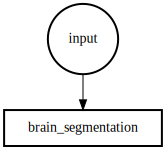

In [10]:
demo_util.display_dot(dot_data=pipeline.make_dot())

## Run computational pipeline job


In [11]:
from datetime import datetime, timezone

In [12]:
pipeline_job = op.PipelineJob(
    pipeline=pipeline,
    input_packet={
        "subject": [
            op.PathSet.UNARY(
                blob=op.Blob(
                    kind=op.BlobKind.FILE,
                    location=op.Uri(namespace="default", path=path),
                    checksum="",
                )
            )
            for path in (
                "brain_mri/axial.jpeg",
                "brain_mri/coronal.jpeg",
                "brain_mri/sagittal.jpeg",
            )
        ],
    },
    output_dir=op.Uri(
        namespace="default", path=f"{data_dir}/brain_segmentation_pipeline"
    ),
    namespace_lookup=namespace_lookup,
)

In [13]:
pipeline_run = await client.start_pipeline_job(pipeline_job=pipeline_job)

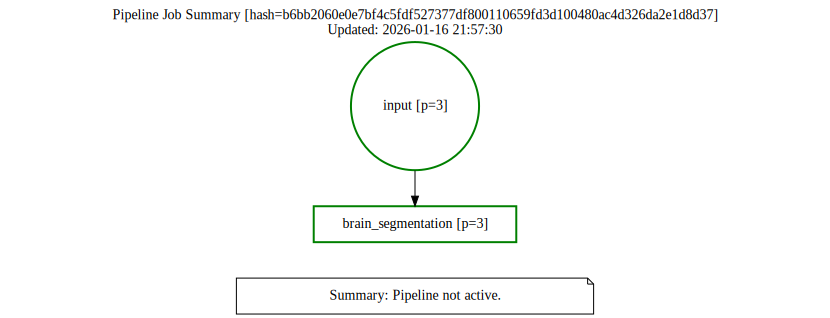

In [14]:
demo_util.animate_display(
    next_display_object=lambda: (
        demo_util.display_dot(dot_data=pipeline_run.summarize_dot())
        if not pipeline_run.terminated()
        or datetime.now(timezone.utc).timestamp() <= pipeline_run.terminated() + 2
        else None
    )
)

In [15]:
pipeline_result = await client.get_pipeline_result(pipeline_run=pipeline_run)

In [16]:
{
    "created": pipeline_result.created,
    "status": pipeline_result.status,
    "terminated": pipeline_result.terminated,
}

{'created': 1768600643,
 'status': <PipelineStatus.COMPLETED: 0>,
 'terminated': 1768600649}


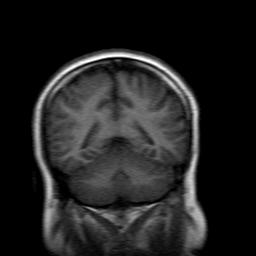
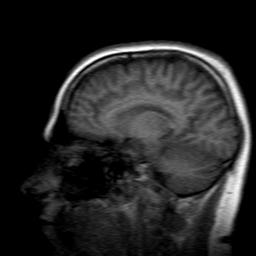
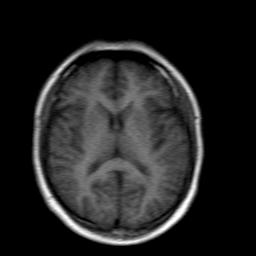


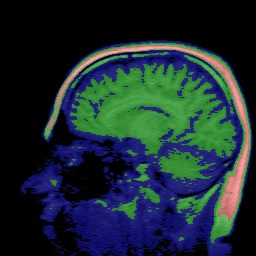
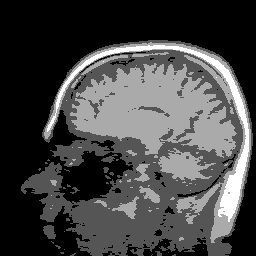
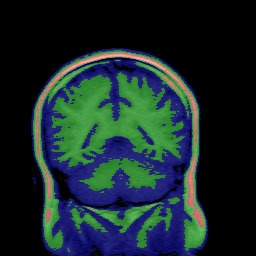
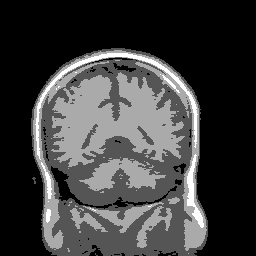
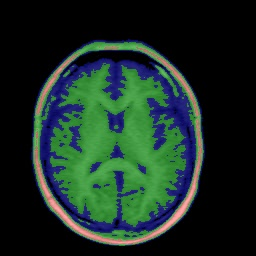
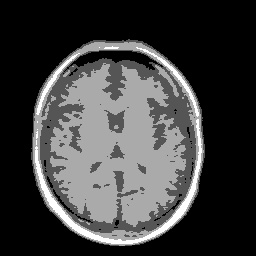

In [17]:
demo_util.display_jpegs("data_lake/brain_mri")
demo_util.display_jpegs("data_lake/data/brain_segmentation_pipeline/brain_segmentation")

## Roadmap

- Educational / Pitching Content
- Simpler, python-friendly experience
- Pipeline of pipelines
- Kubernetes orchestrator
- Queries and data exploration
- Dashboard GUIs
- Multi-agent support
- Tags
- Memoization
- Filter operator
- Agent resource limits
- Support external extensibility


## Teardown


In [18]:
import shutil
from pathlib import Path

In [19]:
shutil.rmtree(Path(namespace_lookup["default"]) / store_dir)
shutil.rmtree(Path(namespace_lookup["default"]) / data_dir)

In [20]:
active_agent.cancel()

True